# Flower Classification

This project will set out to use Tensorflow and Keras to build a deep learning model that is able to accurately predict the the types of flowers in our test set (which has no labels). We will then make our submissions to kaggle to determine how accuarate our model is. Finally, we will attempt to optimize our model and attempt to increase our accuracy score.

To begin we will import all the relevant libraries. From there we will detect our TPUs's, and set up our variables.After this we will then set up a pipeline to decode our images, load our data and seperate our training, validation and test data sets (which are in TFRecord format).

We will then build our model, submit, evaluate and repeat until we are able to optimize our score.

In [1]:
import math, re, os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from functools import partial
from sklearn.model_selection import train_test_split
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.1


In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


## Load Data

In [3]:
from kaggle_datasets import KaggleDatasets

GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')
print(GCS_DS_PATH) # what do gcs paths look like?

gs://kds-5f23a328e9858e85526fdcd85bcc6148c79f0e6b632e7667e469952d


In [4]:
AUTO = tf.data.experimental.AUTOTUNE ## This will be used in num_parallel_reads = AUTO to automatically set the buffer for prefetching?? 

BATCH_SIZE = 16 * strategy.num_replicas_in_sync

IMAGE_SIZE = [512, 512]

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']   

## Lets get the filenames for our data:

GCS_PATH = GCS_DS_PATH + '/tfrecords-jpeg-512x512'

## Use glob pattern to load all the tfrecords across the train, validation and test directories

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec')

In [5]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels = 3) ## Channels refers to colour channels
    image = tf.cast(image, tf.float32) / 255.0 ## Here we are converting image to floats in range [0,1] -- Regularizing
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) ## we need an explicit size for TPU
    return image 

def read_labelled_tfrecord(example):
    LABELLED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64)
    }
    
    example = tf.io.parse_single_example(example, LABELLED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label ## We are returning a dataset of (image, label) pairs

def read_unlabelled_tfrecord(example):
    UNLABELLED_TFREC_FORMAT = {
        'image' : tf.io.FixedLenFeature([], tf.string), ## tf.string Means byte?
        'id' : tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, UNLABELLED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum ## Most likely for the unlabelled test dataset

def load_dataset(filenames, labelled = True, ordered = False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False
    
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads =AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labelled_tfrecord if labelled else read_unlabelled_tfrecord,
                          num_parallel_calls = AUTO)
    
    return dataset

## Create Data Pipelines

Now that we have created functions for loading and decoding our data we are now able to read our tf_records and ultimately then use our data to train a model. Before we get to initializing and training our model we first must create data pipelines and perform some data augmentation to get our data ready for training and testing. 

In [6]:
def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    
    return image, label

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labelled = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.repeat() ## Training set must repeat for several epochs
    
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) ## Prefetch next batch while training (autotune buffer size)
    
    return dataset

def get_validation_dataset(ordered = False):
    dataset = load_dataset(VALIDATION_FILENAMES, labelled = True, ordered = ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(ordered = False):
    dataset = load_dataset(TEST_FILENAMES, labelled = False, ordered = ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_filenames(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n) 
    ## This is a function that grabs the numbers in the filename after the "-" and before the "." (more than 1) 
    ## for each filename in filenames - which was pulled earlier with tf.io.gfile.glob (which used some regex to pull what you want)
 

In [7]:
## Now lets get the total number of filenames across all of our data and create our datasets

ds_train = get_training_dataset()
ds_validate = get_validation_dataset()
ds_test = get_test_dataset()

print("Training:", ds_train)
print("Validation:", ds_validate)
print("Test:", ds_test)
print()



Training: <PrefetchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.int32)>
Validation: <PrefetchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.int32)>
Test: <PrefetchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.string)>



In [8]:
NUM_TRAINING_IMAGES = count_filenames(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_filenames(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_filenames(TEST_FILENAMES)

print("Dataset: {} training images, {} validation images, {} test images".format(NUM_TRAINING_IMAGES, 
                                                                                 NUM_VALIDATION_IMAGES,
                                                                                 NUM_TEST_IMAGES))
 

Dataset: 12753 training images, 3712 validation images, 7382 test images


## Exploring our Data

In [9]:
from matplotlib import pyplot as plt

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy() ## using numpy() is going to give us just the element we are referring to - clean ouput
    numpy_labels = labels.numpy()
    
    if numpy_labels.dtype == object: ## here we are referring to the Image ID strings (binary strings) -> unlabelled
                                        ## If it were the labels the dtype would be an int
        
        numpy_labels = [None for _ in enumerate(numpy_images)]
        ## If there are no labels, only image id's, return None for labels (this is applicable to the test data)
        
        
    return numpy_images, numpy_labels

## It's important at this point to remember our image labels are numbers -> which correspond to a name
## In our submission we will be prediciting the flower by their 'number'

def get_title_from_label_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label]
    
    correct = (label == correct_label)
    
    return "{} [{}{}{}]".format(CLASSES[label], 'Correct' if correct else 'Not Correct', u'\u2192' if not correct else "",
                               CLASSES[correct_label] if not correct else ""), correct


def display_one_flower(image, title, subplot, red = False, titlesize = 16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize = int(titlesize) if not red else int(titlesize/1.2), 
                  color = 'red' if red else 'black', fontdict = {'verticalalignment': 'center'},
                 pad = int(titlesize/1.5))

    return (subplot[0], subplot[1], subplot[2]+1)


def display_batch_of_images(databatch, predictions = None):
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)] ## For test set
    
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
    
    ## Spacing/size
    
    FIGSIZE = 18.0
    SPACING = 0.1
    subplot = (rows, cols, 1)
    
    plt.figure(figsize = (FIGSIZE, FIGSIZE))
    
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = "" if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = get_title_from_label_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows, cols)*40+3
        subplot = display_one_flower(image, title, subplot, not correct, titlesize = dynamic_titlesize)
     
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace = 0, hspace = 0)
    else:
        plt.subplots_adjust(wspace = SPACING, hspace = SPACING)
    
        
    plt.show()
    

def display_training_curves(training, validation, title, subplot):
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

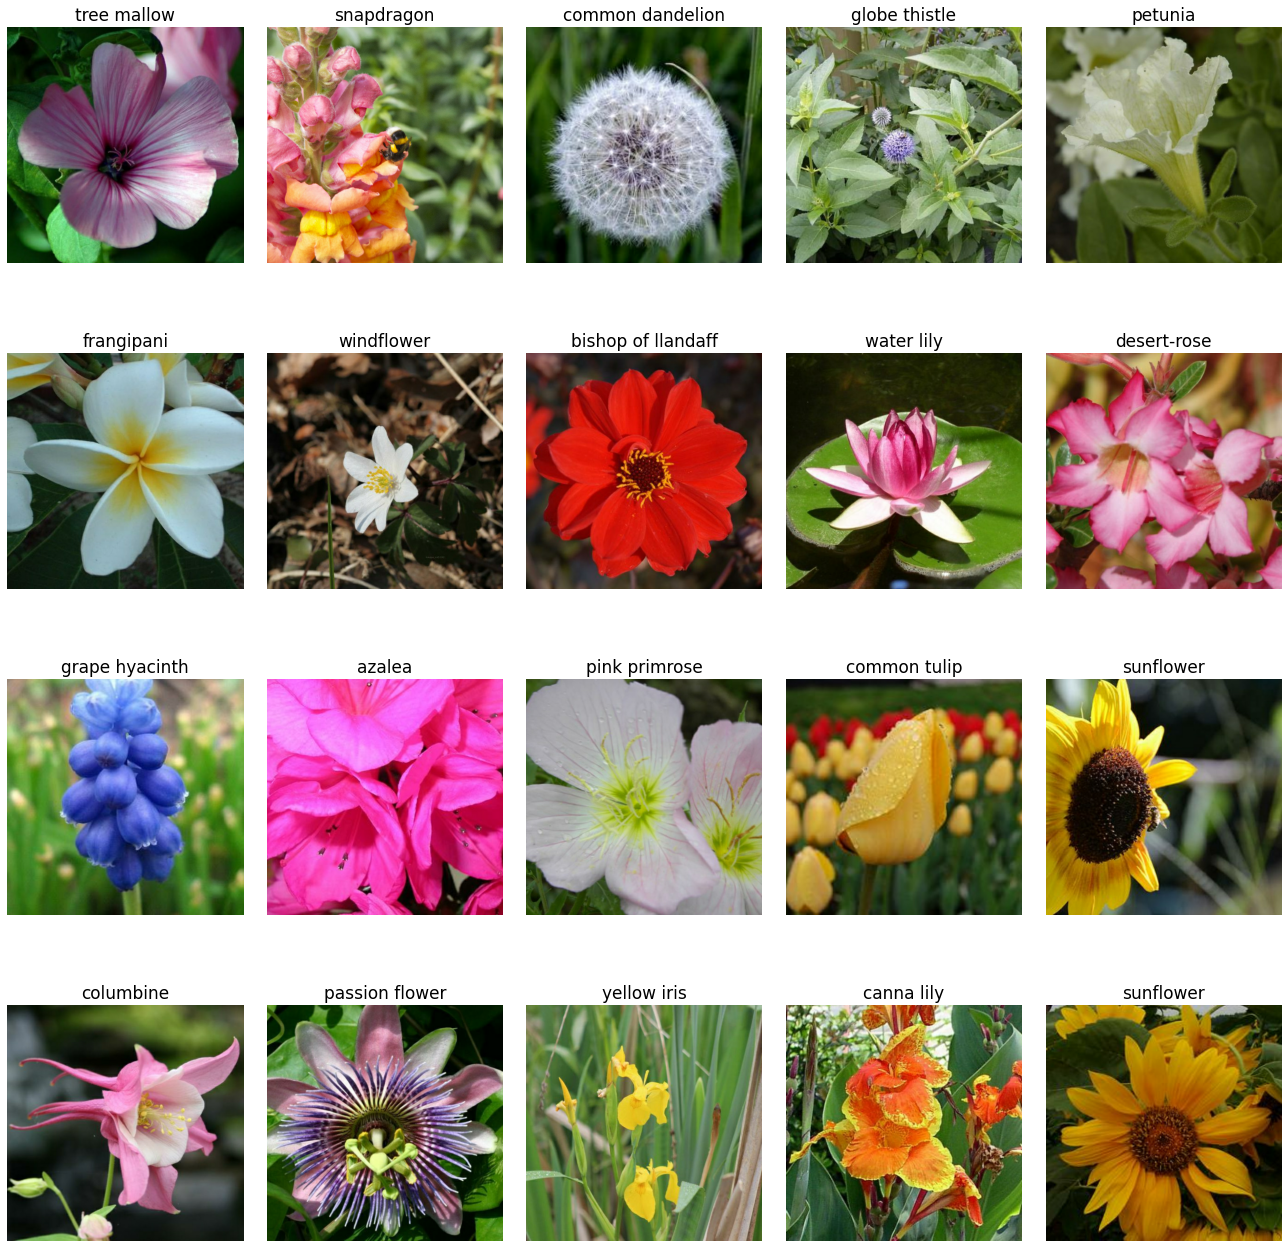

In [10]:
ds_iter = iter(ds_train.unbatch().batch(20))
one_batch = next(ds_iter)

display_batch_of_images(one_batch)

## Defining the Model

Our data is now organised in a way that will allow us the create a neural network for classifying our images.

To make our process easier we will not re-invent the wheel. Rather, we will use **transfer learning**. This means we will use part of a pretrained model to get a head-start on our dataset, instead of building our model from scratch.

There are a variety of models used for image classification. We will begin by using the VGG16 model. We will then try other pretrained models and see if we can further optmize our model.

## VGG16



In [11]:
learning_rate = 1e-4

def make_model():
    base_model = tf.keras.applications.VGG16(
        weights = 'imagenet',
        include_top = False,
        input_shape = [512, 512, 3]
    )
    
    base_model.trainable = True
    
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation = 'softmax')
        ])
    
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
                                            loss = 'sparse_categorical_crossentropy',
                                            metrics = ['sparse_categorical_accuracy'])
    return model

In [12]:
with strategy.scope():
    model = make_model()
    

model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 16, 16, 512)       14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 104)               53352     
Total params: 14,768,040
Trainable params: 14,768,040
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(ds_train,
                   epochs = 10,
                   validation_data = ds_validate,
                   steps_per_epoch = NUM_VALIDATION_IMAGES//BATCH_SIZE)

Epoch 1/10
29/29 [==============================] - 42s 855ms/step - loss: 4.4323 - sparse_categorical_accuracy: 0.0599 - val_loss: 3.8184 - val_sparse_categorical_accuracy: 0.1404
Epoch 2/10
29/29 [==============================] - 15s 532ms/step - loss: 3.7358 - sparse_categorical_accuracy: 0.1711 - val_loss: 3.2377 - val_sparse_categorical_accuracy: 0.2635
Epoch 3/10
29/29 [==============================] - 15s 530ms/step - loss: 3.2161 - sparse_categorical_accuracy: 0.2538 - val_loss: 2.7145 - val_sparse_categorical_accuracy: 0.3702
Epoch 4/10
29/29 [==============================] - 15s 536ms/step - loss: 2.6974 - sparse_categorical_accuracy: 0.3572 - val_loss: 2.3304 - val_sparse_categorical_accuracy: 0.4475
Epoch 5/10
29/29 [==============================] - 15s 535ms/step - loss: 2.2237 - sparse_categorical_accuracy: 0.4628 - val_loss: 1.9015 - val_sparse_categorical_accuracy: 0.5453
Epoch 6/10
29/29 [==============================] - 16s 542ms/step - loss: 1.8848 - sparse_cate

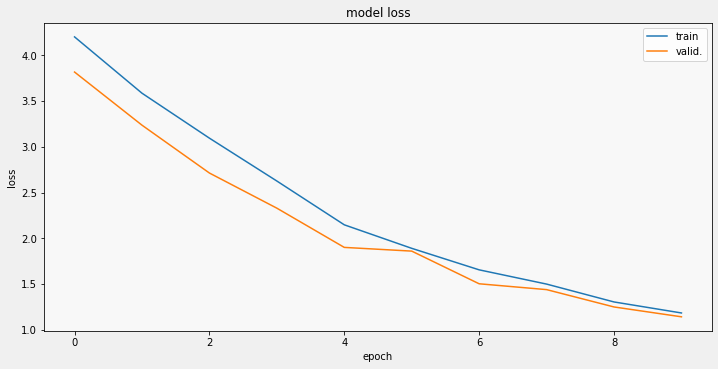

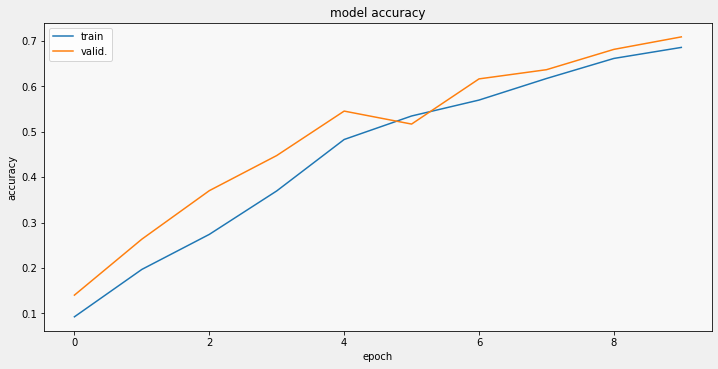

In [14]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history.history['sparse_categorical_accuracy'],
    history.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

As can be seen our model converges, which is a good sign.

## Evaluation of Predictions

Before we use our model to make predictions on our test_ds, we will first analyze the predictions our model made on the validation set. In this way we could diagnose any problems in our training or find ways in which our model can be improved. We will do this in two ways: A confusion matrix and through visual validation.

## Visual Validation

In [15]:
v_data = get_validation_dataset()
v_data = v_data.unbatch().batch(20)
v_batch = iter(v_data)

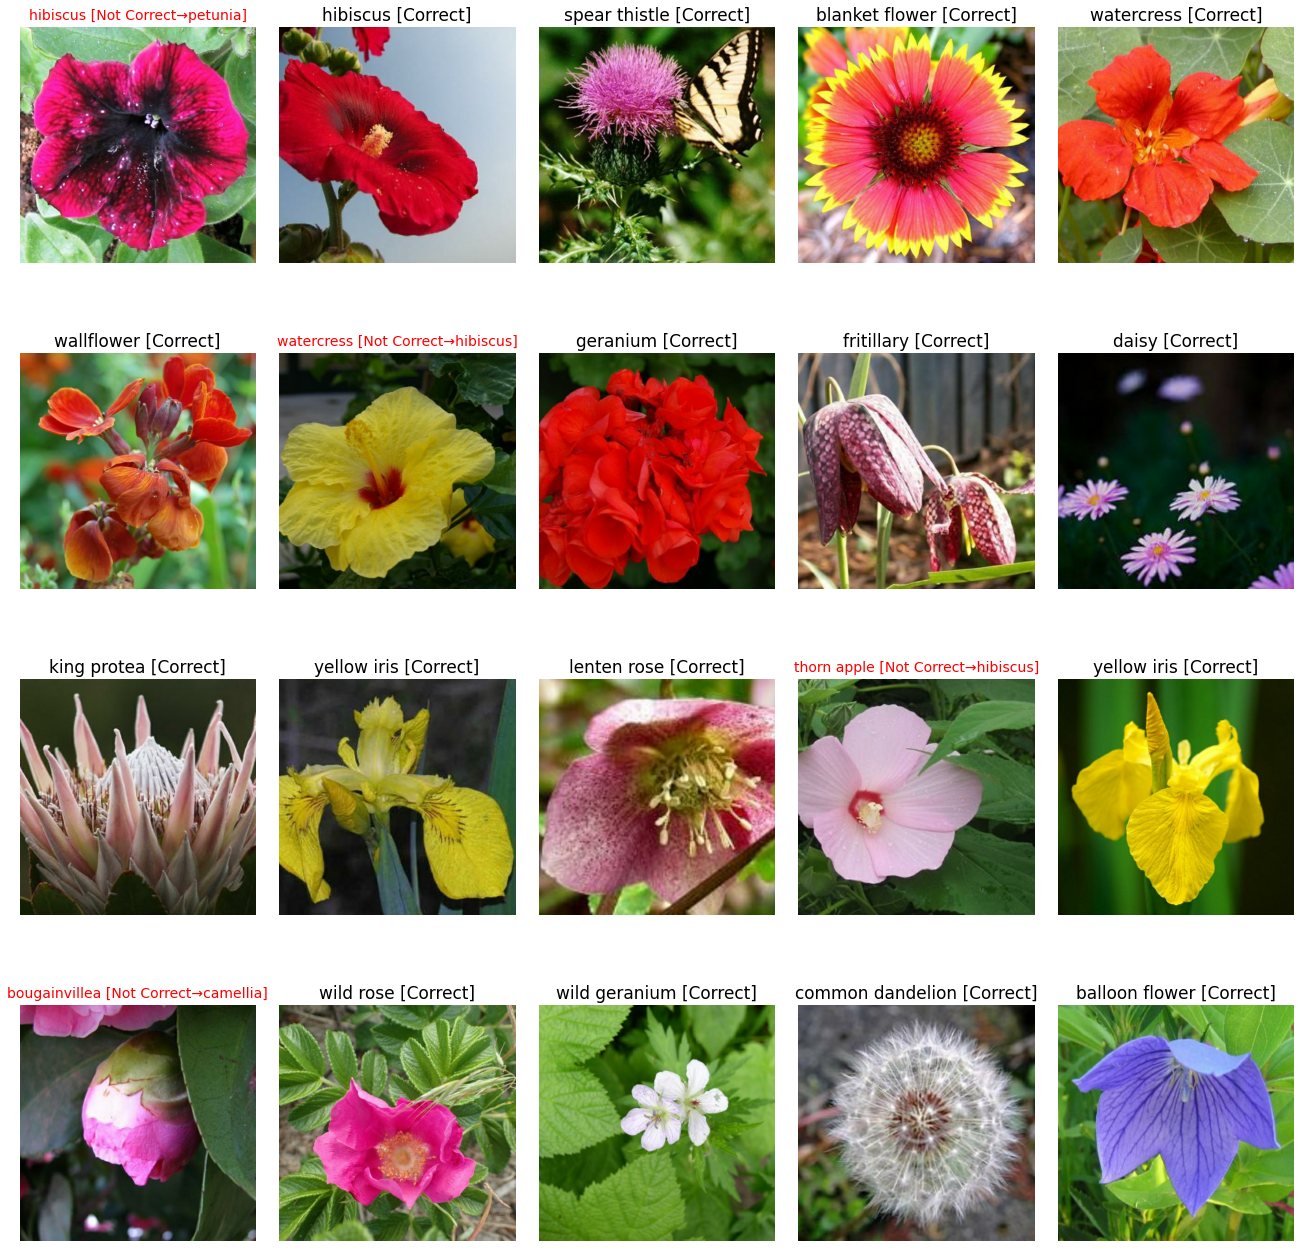

In [16]:
images, labels = next(v_batch)

probs = model.predict(images)

predictions = np.argmax(probs, axis = -1)

display_batch_of_images((images, labels), predictions)

## Confusion Matrix

In [17]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

def display_confusion_matrix(cmat):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.show()
    
def display_metrics(precision, recall, f1):
    met_dict = {'Precision_Score' : [precision], 'Recall_Score': [recall], 'F1_Score': [f1]} 
    df = pd.DataFrame(data = met_dict)
    
    return df


In [18]:
ds_conf = get_validation_dataset(ordered = True)
conf_images = ds_conf.map(lambda image, label: image)
conf_labels = ds_conf.map(lambda image, label: label).unbatch()

correct_val_labels = next(iter(conf_labels.batch(NUM_VALIDATION_IMAGES))).numpy()

conf_probs = model.predict(conf_images)
conf_predictions = np.argmax(conf_probs, axis = -1)

labels = range(len(CLASSES))

cmat = confusion_matrix(correct_val_labels, conf_predictions, labels = labels)

In [19]:
precision_s = precision_score(correct_val_labels, conf_predictions,
                              labels = labels, average = 'macro')

recall_s = recall_score(correct_val_labels, conf_predictions,
                              labels = labels, average = 'macro')

score = f1_score(correct_val_labels, conf_predictions,
                              labels = labels, average = 'macro')

display_metrics(precision_s, recall_s, score)


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision_Score  Recall_Score  F1_Score
0         0.691202      0.571274  0.588949

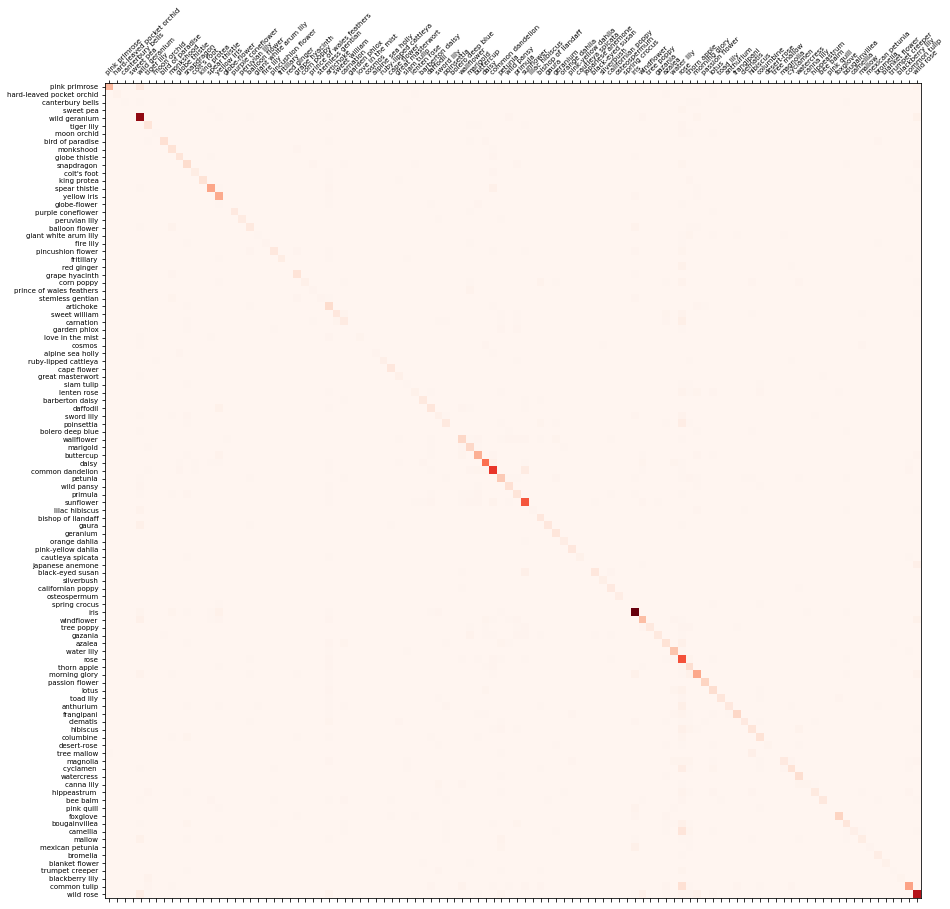

In [20]:
display_confusion_matrix(cmat)

## Results on Validation

Our results look quite good. We have high recall, precision and a good f1 score. When looking at the confusion matrix it seems we have quite good predictions. We are ready now to submit our predicictions on the test_set for the competition to see how well our model performs on unseen data.

## Make Test Predictions

In [21]:
test_ds = get_test_dataset(ordered = True)

test_images_ds = test_ds.map(lambda image, idnum: image)
probs = model.predict(test_images_ds)
predictions = np.argmax(probs, axis = -1)

test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

np.savetxt(
    'submission.csv',
    np.rec.fromarrays([test_ids, predictions]),
    fmt=['%s', '%d'],
    delimiter=',',
    header='id,label',
    comments='',
)

!head flower_submission.csv

head: cannot open 'flower_submission.csv' for reading: No such file or directory
